In [1]:
import sys
sys.path.append("/home/jaxmao/jaxmaov2_/JaxMao/")

In [2]:
import pickle, cv2
from sklearn.utils import shuffle

def load_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def load_GTSRB(color='rgb'):
    if not color in ['rgb', 'hsv']:
        return False
    X_train = load_pickle_file('/home/jaxmao/jaxmao/dataset/GTSRB_hsv/X_train.pkl')
    y_train = load_pickle_file('/home/jaxmao/jaxmao/dataset/GTSRB_hsv/y_train.pkl')
    X_test = load_pickle_file('/home/jaxmao/jaxmao/dataset/GTSRB_hsv/X_test.pkl')
    y_test = load_pickle_file('/home/jaxmao/jaxmao/dataset/GTSRB_hsv/y_test.pkl')

    if color == 'rgb':
        for i in range(len(X_train)):
            X_train[i] = cv2.cvtColor(X_train[i].astype('float32'), cv2.COLOR_HSV2RGB)
        for i in range(len(X_test)):
            X_test[i] = cv2.cvtColor(X_test[i].astype('float32'), cv2.COLOR_HSV2RGB)
    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = load_GTSRB(color='rgb')

In [3]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

# Build and train the model

start by importing neccessary layers, loss, optimizer, and initializer(optional) <br>
initiate jax random key with seed=24

In [4]:
from jaxmao.modules import Module, Bind, Conv2d, BatchNorm2d, GlobalAveragePooling2d, MaxPooling2d
from jaxmao.regularizers import L1L2
from jaxmao.optimizers import Adam
from jaxmao.losses import CategoricalCrossEntropy
from jaxmao import initializers as init
import jax

key = jax.random.key(24)

I0000 00:00:1701317680.455006    4203 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


define helper class `ConvBNRelu` and the main model `Classifier`

In [23]:
max_pool2d = MaxPooling2d(strides=(1,1))

class ConvBnRelu(Module):
    def __init__(self, in_channels, out_channels, activation=None, strides=1, kernel_size=3):
        super().__init__()
        self.conv = Conv2d(in_channels, out_channels, kernel_size=kernel_size, strides=strides, padding='valid', use_bias=False, kernel_init=init.GlorotUniform())
        self.bn = BatchNorm2d(out_channels)
        self.activation = activation
    
    def call(self, inputs):
        x = self.bn(self.conv(inputs))
        return self.activation(x) if self.activation else x

class Classifier(Module):
    def __init__(self):
        super().__init__()
        self.bn0 = BatchNorm2d(3)
        self.conv1 = ConvBnRelu(3, 32, jax.nn.relu, 2)
        self.conv2 = ConvBnRelu(32, 32, jax.nn.relu, 1)
        self.conv3 = ConvBnRelu(32, 64, jax.nn.relu, 2)
        self.conv4 = ConvBnRelu(64, 64, jax.nn.relu, 1)
        
        self.conv_expand = ConvBnRelu(64, 512, jax.nn.relu, 1, 1)
        self.conv_out = ConvBnRelu(512, 43, None, strides=1, kernel_size=1)
        self.gap = GlobalAveragePooling2d()
        
    def call(self, x):
        x = self.bn0(x)
        x = max_pool2d(self.conv2(self.conv1(x)))
        x = max_pool2d(self.conv4(self.conv3(x)))
        return jax.nn.softmax(self.gap(self.conv_out(self.conv_expand(x))))

initialize parameters and states.

In [24]:
clf = Classifier()
params, states = clf.init(key)

define training step

In [25]:
optimizer = Adam(params, lr=1e-2)
cce_loss = CategoricalCrossEntropy(eps=1e-6)

@jax.jit
def train_step(params, states, optim_state, X, y):
    def apply_loss(params, states, X, y):
        prediction, states, reg = clf.apply(X, params, states)
        return cce_loss(prediction, y) + reg, states
    (loss_value, states), gradients = jax.value_and_grad(apply_loss, argnums=0, has_aux=True)(params, states, X, y)
    params, optim_state = optimizer.step(params, gradients, optim_state)
    return loss_value, params, states, optim_state

training loop

In [26]:
EPOCHS = 10
BATCH_SIZE = 128
BATCH_NUMS = len(X_train) // BATCH_SIZE

for epoch in range(EPOCHS):
    toltal_losses = 0.0
    for batch_idx in range(BATCH_NUMS):
        starting_idx = batch_idx*BATCH_SIZE
        ending_idx= (batch_idx+1)*BATCH_SIZE
        loss_value, params, states, optimizer.states = train_step(params, states, optimizer.states, X_train[starting_idx:ending_idx], y_train[starting_idx:ending_idx])
        toltal_losses += loss_value
    loss = toltal_losses / BATCH_NUMS
    print(f"{epoch} loss: {loss}")

0 loss: 1.2757177352905273
1 loss: 0.10176257789134979
2 loss: 0.039843302220106125
3 loss: 0.022848956286907196
4 loss: 0.007841520942747593
5 loss: 0.012049206532537937
6 loss: 0.016893059015274048
7 loss: 0.009250650182366371
8 loss: 0.0015493474202230573
9 loss: 0.021192414686083794


In [1]:
from sklearn.metrics import accuracy_score

with Bind(clf, params, states) as ctx:
    predictions = ctx.module(X_test)
    predictions_cls = predictions.argmax(axis=1)
    accuracy = accuracy_score(y_test.argmax(axis=1), predictions_cls)
accuracy

NameError: name 'Bind' is not defined

11
11


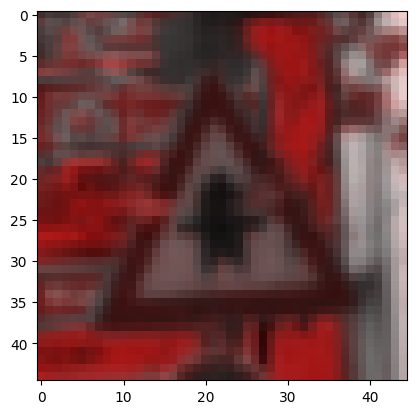

In [52]:
import matplotlib.pyplot as plt

plt.imshow(X_test[0])
print(y_test[0].argmax())
print(predictions_cls[0])
plt.show()